In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ='darkgrid', font_scale=1.5)
plt.rcParams['font.sans-serif'] =['SimHei']
plt.rcParams['axes.unicode_minus'] =False


# 1、数据查看

In [ ]:
data_user = pd.read_csv('tianchi_mobile_recommend_train_user.csv',dtype = str)

In [ ]:
#如电脑比较弱（4G内存，cpu比较弱） 在这里选前100万条数据即可
data_user.info()

In [ ]:
data_user.head()

# 2 数据预处理

In [ ]:
#2.1 缺失值分析，apply默认对列进行操作，x代表一列
data_user.apply(lambda x: sum(x.isnull())/len(x))  # 只有地理位置列有缺失值


In [ ]:
data_user.apply(lambda x: sum(x.isnull()))

In [ ]:
data_user.shape

In [ ]:
#把日期和小时分别取出来
data_user['date'] = data_user['time'].str[0:10]
data_user['hour'] = data_user['time'].str[11:]  #如果发生溢出就分开执行

In [ ]:
data_user.dtypes

In [ ]:
data_user.head()

In [ ]:
data_user['date'] = pd.to_datetime(data_user['date'])
data_user['time']= pd.to_datetime(data_user['time'])
data_user['hour'] = data_user['hour'].astype(int)

In [ ]:
data_user.dtypes

In [ ]:
data_user.head()

In [ ]:
#对数据进行一下排序
data_user.sort_values(by ='time',ascending=True,inplace = True)  # 升序

In [ ]:
data_user.head()

In [ ]:
data_user.tail()

In [ ]:
#丢弃原有索引，按位置重新生成索引，在原有df生效
data_user.reset_index(drop =True,inplace =True)

In [ ]:
data_user.head()

In [ ]:
# top是出现最多次数的那个str值，freq是top内的值出现的次数
data_user.describe(include = ['object'])  #第二行可以看出行为类型，用户位置类别，商品品类

In [ ]:
data_user[data_user['user_geohash']=='94ek6ke']

In [ ]:
data_user.describe(include = 'all')

# 构建模型

In [ ]:
pv_daily = data_user.groupby('date').count()['user_id']

In [ ]:
#得到了每天的pv（日活）
pv_daily.head()

In [ ]:
#如果不小心把名字弄错了，不需要重新读取数据，直接改列名
#改为user_id1的目的是为了下面命名为pv,uv做准备
pv_daily = pv_daily.rename('user_id1') #注意这里一定要写赋值

In [ ]:
# #显示所有列
# pd.set_option('display.max_columns', None)
# #显示所有行
# pd.set_option('display.max_rows', None)
# #设置value的显示长度为100，默认为50
# pd.set_option('max_colwidth',100)

In [ ]:
data_user.groupby('date')['user_id'].head(3)

In [ ]:
#如何计算uv，针对用户访问进行去重，再计算数目
uv_daily = data_user.groupby('date')['user_id'].apply(lambda x:x.drop_duplicates().count())


In [ ]:
uv_daily.head()

In [ ]:
pv_uv_daily = pd.concat([pv_daily, uv_daily],axis=1)


In [ ]:
pv_uv_daily.head()

In [ ]:
pv_uv_daily.rename(columns={'user_id1':'pv','user_id':'uv'},inplace =True)


In [ ]:
pv_uv_daily.head()

In [ ]:
pv_uv_daily.head(5).to_csv('pv_uv.csv')

In [ ]:
# pv_uv_daily.head(5).to_excel('pv_uv.xls')

In [ ]:
pv_uv_daily.corr(method = 'spearman')

In [ ]:
pv_uv_daily.corr(method = 'pearson')  #皮尔逊相关系数,到推荐那里讲

In [ ]:
#上面说明每天的访问量和访问用户是正相关的关系

In [ ]:
pv_daily.head(100)

In [ ]:
#默认显示一个月的区别
plt.figure(figsize=(16,9))
plt.subplot(211)  #等价于2,1,2，是2行1列图，这里是第一个图
plt.plot(pv_daily, color='red')  #pv_daily是一个series，
plt.title('每天访问量')
plt.subplot(212)
plt.plot(uv_daily,color='green')
plt.title('每天访问用户数')
plt.suptitle('UV和PV变化趋势')
plt.show()


In [ ]:
#结论：上面两幅图可以发现双12达到峰值

In [ ]:
#小时的pv
pv_daily = data_user.groupby('hour').count()['user_id']

In [ ]:
pv_daily.head(30)

In [ ]:
#小时的uv
uv_daily = data_user.groupby('hour')['user_id'].apply(lambda x:x.drop_duplicates().count())

In [ ]:
uv_daily.head(30)

In [ ]:
pv_uv_daily = pd.concat([pv_daily, uv_daily],axis=1)

In [ ]:
pv_uv_daily.columns=['pv','uv']

In [ ]:
pv_uv_daily.head()

In [ ]:
pv_uv_daily.corr(method = 'spearman')

In [ ]:
pv_uv_daily.corr(method = 'pearson')  #皮尔逊相关系数

In [ ]:
plt.figure(figsize=(16,9))
pv_uv_daily['pv'].plot(color= 'steelblue', label ='每个小时访问量')
plt.legend(loc ='upper center')
plt.ylabel('访问量')
pv_uv_daily['uv'].plot(color= 'red', label='每个小时不同用户访问量',secondary_y =True)
plt.ylabel('访问用户数')
plt.xticks(range(0,24),pv_uv_daily.index)
plt.legend(loc ='upper center')
plt.grid(True)
plt.show()

# 2 用户消费行为分析

In [ ]:
#先看下上面的数据
pv_detail = pd.pivot_table(columns ='behavior_type',index ='hour' , data = data_user,values = 'user_id',aggfunc=np.size)

In [ ]:
pv_detail #点击、收藏、加入购物车和支付 的比例

In [ ]:
plt.figure(figsize=(16,9))
sns.lineplot(data = pv_detail)  #可以实现一图多线
plt.show()

In [ ]:
#因为点击量很高，所以应该去把收藏，购物车，支付单独画一个图
#图中显示的图例名字，就是列名
plt.figure(figsize=(16,9))
sns.lineplot(data = pv_detail.iloc[:,1:])
plt.show()

In [ ]:
#统计这一个月内用户的支付行为次数
# data_user_buy = data_user[data_user.behavior_type =='4'].groupby('user_id').count()
data_user_buy = data_user[data_user.behavior_type =='4'].groupby('user_id').size()

In [ ]:
data_user_buy.head()

In [ ]:
data_user_buy.describe()  #可以知道大部分用户一个月的购买次数是8次（中值）

In [ ]:
data_user_buy_more=data_user_buy[data_user_buy<70]
print(len(data_user_buy_more)/len(data_user_buy))
plt.hist(x =data_user_buy_more, bins=30)
plt.show()

In [ ]:
#日ARPPU

In [ ]:
#查看每个用户，每天的支付次数
data_user_buy1= data_user[data_user.behavior_type =='4' ].groupby(['date' , 'user_id'])

In [ ]:
data_user_buy1.count()

In [ ]:
data_user_buy1.head(3)  # 承接318行，理解先分组，再聚合

In [ ]:
#reset_index原有的索引列就会变为数据列
data_user_buy1.count()['behavior_type'].reset_index().rename(columns={'behavior_type':' total'})  #按照日期不同用户的购买行为次数
data_user_buy1

In [ ]:
#结合上面两步
data_user_buy1= data_user[data_user.behavior_type =='4' ].groupby(['date' , 'user_id']).count()['behavior_type'].reset_index().rename(columns={'behavior_type':'total'})

In [ ]:
data_user_buy1

In [ ]:
data_user_buy1.head(10)

In [ ]:
#每天用户的平均支付次数
data_user_buy2=data_user_buy1.groupby('date').sum()['total']/ data_user_buy1.groupby('date').count()['total']

In [ ]:
#每天用户的平均支付次数
data_user_buy2

In [ ]:
data_user_buy2.plot()  #因为数据是11月18号到12月18号的
plt.show()

In [ ]:
data_user_buy2.describe()   #发现每天有支付行为用户的平均购物次数是2.3次

In [ ]:
#日ARPU

In [ ]:
data_user['operation']=1  #增加一列操作
data_user_buy2 = data_user.groupby(['date' , 'user_id' , 'behavior_type'])['operation'].count()


In [ ]:
data_user_buy2

In [ ]:
data_user_buy2=data_user_buy2.reset_index().rename(columns ={'operation':'total'})

In [ ]:
data_user_buy2

In [ ]:
#把上面两步结合到一起
data_user_buy2 = data_user.groupby(['date' , 'user_id' , 'behavior_type'])['operation'].count().reset_index().rename(columns ={'operation':'total'})

In [ ]:
data_user_buy2

In [ ]:
#每天的活跃用户消费次数，假设是ARPU
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type =='4' ].total.sum()/len(x.user_id.unique()))

In [ ]:
#对ARPU进行画图
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type =='4' ].total.sum()/len(x.user_id.unique())).plot()

In [ ]:
data_user_buy2

In [ ]:
#结论：上图可以看出用户平均每天购物不到1次，双12的时候达到快2次

In [ ]:
data_user_buy2

In [ ]:
#某一天有多少人发生了购买行为（一天某个人购买多次，只记一次）
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type =='4' ].total.count())

In [ ]:
data_user_buy2.groupby('date').apply(lambda x:len(x.user_id.unique()))  # 所有行为用户，不仅仅是支付行为

In [ ]:
#每天的购买人数的比例,付费率
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type =='4' ].total.count()/len(x.user_id.unique()))

In [ ]:
#结论：可以看出平时只有20%的用户有消费行为，但是双12有50%的用户有消费行为

In [ ]:
#画图展示，df自带的plot
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type =='4' ].total.count()/len(x.user_id.unique())).plot()

In [ ]:
data_user_buy3 = data_user[data_user['behavior_type'] == '4'].groupby(['user_id' , 'date', 'hour'])['operation'].sum()

data_user_buy3

c:\users\waitp\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='operation', ylabel='Density'>

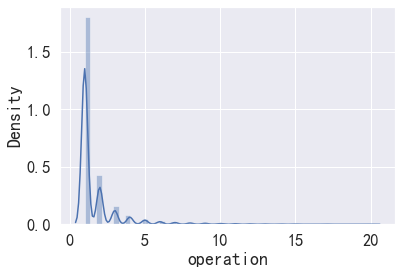

In [78]:
#在某个小时内购买次数的一个分布
data_user_buy4=data_user_buy3[data_user_buy3<=20]
sns.distplot(data_user_buy4)


In [ ]:
#上面分析了用户购买都是在哪个时间段发生的，看0-23

# 3 复购行为分析

In [79]:
#groupby user，对日期进行去重，同一天购买不算复购
data_rebuy = data_user[data_user.behavior_type =='4'].groupby('user_id')['date'].apply(lambda x: len(x. unique()))

In [80]:
#辅助理解，单独把某个用户拿出来来看，判断代码是否正确
data_user[data_user.behavior_type =='4'][data_user['user_id']=='100011562'].groupby('date').count()

C:\Users\waitp\AppData\Local\Temp\ipykernel_11052\59081353.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_user[data_user.behavior_type =='4'][data_user['user_id']=='100011562'].groupby('date').count()


,user_id,item_id,behavior_type,user_geohash,item_category,time,hour,operation
date,,,,,,,,
2014-12-12,1,1,1,0,1,1,1,1
2014-12-14,1,1,1,0,1,1,1,1
2014-12-16,1,1,1,0,1,1,1,1


In [81]:
data_rebuy  #知道每个用户购买了多少次

user_id
100001878    15
100011562     3
100012968    11
100014060    12
100024529     9
             ..
99960313      5
9996155       3
99963140      8
99968428      9
99989881     13
Name: date, Length: 8886, dtype: int64

In [84]:
#只要在30天内购买次数大于等于2次，就是复购
data_rebuy[data_rebuy>=2].count()/data_rebuy.count()  #复购行为达到87%


0.8717083051991897

## 3.1 接下来看复购时间间隔

In [87]:
# data_user.head()
print(type(data_user))

<class 'pandas.core.frame.DataFrame'>


In [111]:
#显示所有行
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 30)


In [112]:
data_day_buy = data_user[data_user.behavior_type == '4'].groupby('user_id').date.apply(lambda x:x.sort_values())
data_day_buy

user_id            
100001878  270407     2014-11-18
           2439076    2014-11-24
           2439090    2014-11-24
           2440428    2014-11-24
           2660355    2014-11-25
           2672617    2014-11-25
           3076142    2014-11-26
           3178225    2014-11-26
           3075867    2014-11-26
           3627084    2014-11-27
           4041992    2014-11-29
           4121098    2014-11-29
           5844240    2014-12-03
           6034745    2014-12-04
           5990081    2014-12-04
                         ...    
99989881   8914       2014-11-18
           10983      2014-11-18
           809671     2014-11-20
           2418573    2014-11-24
           2669776    2014-11-25
           3960969    2014-11-28
           4742925    2014-11-30
           5381458    2014-12-02
           6292411    2014-12-04
           6372246    2014-12-05
           8203371    2014-12-09
           9248497    2014-12-12
           9249028    2014-12-12
           10601909   2

In [160]:
data_user.iloc[270407]

user_id                    100001878
item_id                     90840123
behavior_type                      4
user_geohash                 97lbtnd
item_category                  11497
time             2014-11-18 20:00:00
date             2014-11-18 00:00:00
hour                              20
operation                          1
Name: 270407, dtype: object

In [115]:
#diff是将下一行的数据，减去上一行，就得到了复购时间间隔，是days,每个用户的第一行是nan，所以要dropna
data_day_buy = data_day_buy.diff(1).dropna()


In [116]:
data_day_buy

user_id            
100001878  2439076    6 days
           2439090    0 days
           2440428    0 days
           2660355    1 days
           2672617    0 days
           3076142    1 days
           3178225    0 days
           3075867    0 days
           3627084    1 days
           4041992    2 days
           4121098    0 days
           5844240    4 days
           6034745    1 days
           5990081    0 days
           6034724    0 days
                       ...  
99989881   8914       0 days
           10983      0 days
           809671     2 days
           2418573    4 days
           2669776    1 days
           3960969    3 days
           4742925    2 days
           5381458    2 days
           6292411    2 days
           6372246    1 days
           8203371    4 days
           9248497    3 days
           9249028    0 days
           10601909   2 days
           11085567   1 days
Name: date, Length: 120204, dtype: timedelta64[ns]

In [117]:
data_day_buy.map(lambda x: x.days)

user_id            
100001878  2439076     6
           2439090     0
           2440428     0
           2660355     1
           2672617     0
           3076142     1
           3178225     0
           3075867     0
           3627084     1
           4041992     2
           4121098     0
           5844240     4
           6034745     1
           5990081     0
           6034724     0
                      ..
99989881   8914        0
           10983       0
           809671      2
           2418573     4
           2669776     1
           3960969     3
           4742925     2
           5381458     2
           6292411     2
           6372246     1
           8203371     4
           9248497     3
           9249028     0
           10601909    2
           11085567    1
Name: date, Length: 120204, dtype: int64

# 4 漏斗分析

In [118]:
data_day_buy4=data_day_buy
data_day_buy4

user_id            
100001878  2439076    6 days
           2439090    0 days
           2440428    0 days
           2660355    1 days
           2672617    0 days
           3076142    1 days
           3178225    0 days
           3075867    0 days
           3627084    1 days
           4041992    2 days
           4121098    0 days
           5844240    4 days
           6034745    1 days
           5990081    0 days
           6034724    0 days
                       ...  
99989881   8914       0 days
           10983      0 days
           809671     2 days
           2418573    4 days
           2669776    1 days
           3960969    3 days
           4742925    2 days
           5381458    2 days
           6292411    2 days
           6372246    1 days
           8203371    4 days
           9248497    3 days
           9249028    0 days
           10601909   2 days
           11085567   1 days
Name: date, Length: 120204, dtype: timedelta64[ns]

In [119]:
data_user_count = data_user.groupby('behavior_type').size()
data_user_count #四种行为的数量  点击、收藏、加入购物车和支付


behavior_type
1    11550581
2      242556
3      343564
4      120205
dtype: int64

In [120]:
#看总的pv
pv_all = data_user['user_id'].count()
pv_all

12256906

In [121]:
#流失率不是很合理，正常流失率是进入后，什么行为都没做
(pv_all - data_user_count[0])/pv_all  #总浏览量中有多少人没有点击就离开了，这个就是流失率

0.05762669632939993

In [122]:
data_user_count[0]

11550581

In [124]:
(data_user_count[0] - data_user_count[2])/data_user_count[0]  #有多少人点击了但是没有加入购物车


0.9702556953628566

In [125]:
# 有点问题：岂不是默认收藏了的一定加入了购物车？
# (data_user_count[2] - data_user_count[1])/data_user_count[2] #并不是所有加入购物车的人都进行了收藏，有29%的人并没有收藏

0.29400053556251526

In [126]:
# (data_user_count[1] - data_user_count[3])/data_user_count[1] #收藏的人有50%进行了支付；也不合理

0.5044237207077953

In [127]:
(data_user_count[2] - data_user_count[3])/data_user_count[2] #加入购物车的人有65%的人没有进行支付

0.6501234122317822

# 5 RFM分析

In [128]:
from datetime import datetime

In [130]:
recent_buy_time=data_user[data_user['behavior_type'] == '4'].groupby ('user_id')['date'].apply(lambda x:datetime(2014,12,20)- x.sort_values().iloc[-1])

#每个用户最新的购买日期和参考日期之间的时间间隔
recent_buy_time

user_id
100001878    2 days
100011562    4 days
100012968    2 days
100014060    2 days
100024529    4 days
100027681    6 days
100035725    2 days
100039408   31 days
100042340    2 days
10004287    20 days
100067745    8 days
100078685    6 days
100086267    3 days
100090063    8 days
100097997    4 days
              ...  
99792011     3 days
99795650     2 days
99796192     5 days
99796276     2 days
99851929     4 days
99856680     8 days
99877834     5 days
99891846     3 days
99900937     3 days
99926967     6 days
99960313     7 days
9996155     13 days
99963140     5 days
99968428     6 days
99989881     5 days
Name: date, Length: 8886, dtype: timedelta64[ns]

In [131]:
recent_buy_time=recent_buy_time.reset_index().rename(columns={'date':'recent'})

In [132]:
recent_buy_time

,user_id,recent
0,100001878,2 days
1,100011562,4 days
2,100012968,2 days
3,100014060,2 days
4,100024529,4 days
5,100027681,6 days
6,100035725,2 days
7,100039408,31 days
8,100042340,2 days
9,10004287,20 days


In [133]:
recent_buy_time.recent= recent_buy_time.recent.apply(lambda x: x.days)  #去掉days


In [134]:
recent_buy_time


,user_id,recent
0,100001878,2
1,100011562,4
2,100012968,2
3,100014060,2
4,100024529,4
5,100027681,6
6,100035725,2
7,100039408,31
8,100042340,2
9,10004287,20


In [137]:
buy_freq = data_user[data_user ['behavior_type'] =='4'].groupby('user_id').date.count()
buy_freq

user_id
100001878    36
100011562     3
100012968    15
100014060    24
100024529    26
100027681    48
100035725     4
100039408     1
100042340     3
10004287     14
100067745    12
100078685    19
100086267    48
100090063     6
100097997    11
             ..
99792011     19
99795650     50
99796192     10
99796276     43
99851929      5
99856680      3
99877834     11
99891846      7
99900937     27
99926967     10
99960313      8
9996155       6
99963140     19
99968428     38
99989881     17
Name: date, Length: 8886, dtype: int64

In [139]:
buy_freq=buy_freq.reset_index().rename(columns={'date':'freq'})
buy_freq

,index,user_id,freq
0,0,100001878,36
1,1,100011562,3
2,2,100012968,15
3,3,100014060,24
4,4,100024529,26
5,5,100027681,48
6,6,100035725,4
7,7,100039408,1
8,8,100042340,3
9,9,10004287,14


In [148]:
rfm= pd.merge (recent_buy_time, buy_freq,left_on ='user_id' ,right_on ='user_id')


In [149]:
rfm

,user_id,recent,index,freq
0,100001878,2,0,36
1,100011562,4,1,3
2,100012968,2,2,15
3,100014060,2,3,24
4,100024529,4,4,26
5,100027681,6,5,48
6,100035725,2,6,4
7,100039408,31,7,1
8,100042340,2,8,3
9,10004287,20,9,14


In [155]:
rfm['recent_value'] = pd.qcut(rfm.recent,2,labels=['2','1'])

In [156]:
rfm['freq_value'] = pd.qcut(rfm.freq,2,labels=['1','2'])

In [157]:
rfm['rfm'] = rfm['recent_value'].str.cat(rfm['freq_value'])


In [158]:
rfm  # 22是最佳

,user_id,recent,index,freq,recent_value,freq_value,rfm
0,100001878,2,0,36,2,2,22
1,100011562,4,1,3,2,1,21
2,100012968,2,2,15,2,2,22
3,100014060,2,3,24,2,2,22
4,100024529,4,4,26,2,2,22
5,100027681,6,5,48,2,2,22
6,100035725,2,6,4,2,1,21
7,100039408,31,7,1,1,1,11
8,100042340,2,8,3,2,1,21
9,10004287,20,9,14,1,2,12


In [159]:
rfm1 = rfm.rfm.sort_values(ascending=False)
rfm1


0       22
4569    22
4517    22
4516    22
4514    22
4513    22
4512    22
4510    22
4509    22
4508    22
4507    22
4502    22
4499    22
4498    22
4497    22
        ..
6849    11
6850    11
737     11
6852    11
6855    11
5247    11
6857    11
5246    11
1987    11
5245    11
3270    11
6862    11
3268    11
1989    11
2336    11
Name: rfm, Length: 8886, dtype: object